In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import matplotlib
import ipyparams

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib_dev_optControl.neurolib.models.aln import ALNModel
from neurolib_dev_optControl.neurolib.utils import plotFunctions as plotFunc
from neurolib_dev_optControl.neurolib.utils import func_optimize as fo
from neurolib_dev_optControl.neurolib.utils import costFunctions as cost
import neurolib_dev_optControl.neurolib.dashboard.functions as functions
import neurolib_dev_optControl.neurolib.dashboard.data as data
import neurolib_dev_optControl.neurolib.dashboard.layout as layout
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

cmap_ = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors_rgba()
exc_red = cmap_(3)
inh_blue=cmap_(0)
green = cmap_(2)

<IPython.core.display.Javascript object>

not here


In [2]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [3]:
savepath = (os.getcwd().split('neurolib')[0] + 'Talks_Conf_Workshops_Schools' + os.sep + '22' + os.sep + 'FRANCE22' + 
     os.sep + 'ENCODS' + os.sep + 'poster' + os.sep + 'images')

exc = 0.4
inh = 0.322

In [4]:
dur_pre = 10
dur_post = 10
dur = 500.
dt = aln.params.dt
T = int(1 + dur / dt)

max_it = 10
init_it = 10
prec_vars = [0,1]
trans_time = 0.7
repeat = 20

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

maxC = [5., -5., 0.18, 0.]
n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

nb = ipyparams.notebook_name
print('nb = ', nb)

max_I = [3., -3.]

read_file = '..' + os.sep + '..' + os.sep + 'data_2' + os.sep + 'high_osc' + os.sep  + '1_I.pickle'

nb =  


In [5]:
if os.path.isfile(read_file) :
    print("file found")
    
    with open(read_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl = load_array
    
init_control_noisefree = bestControl[0].copy()

file found


In [6]:
sigma_ou_array = [0.01, 0.02]
noise_realizations_array = [0,20,50]
noise_realizations_final = 10000

In [7]:
n_sig = len(sigma_ou_array)
n_noise = len(noise_realizations_array)

i_sigma = 0
i_noise = 1
i = 50

int_t_pen = np.around( (1. - trans_time)*dur/aln.params.dt, 1).astype(int)

cost_final_mean = np.zeros(( n_sig,n_noise ))
target = [None] * n_sig
control_ = [ [None] * n_noise, [None] * n_noise ]
cost_ = control_.copy()
cost_final = control_.copy()

stable_state = np.zeros(( n_noise, 2,2,2, 2))

In [8]:
cost_final_mean = np.zeros(( n_sig,n_noise ))

In [9]:
# get init vars without noise
aln = ALNModel()
data.set_parameters(aln)
aln.params.duration = 3000.

# initial without noise
control0 = aln.getZeroControl()
control0[0,0,:500] = -5.

aln.params.ext_exc_current = exc * 5.
aln.params.ext_inh_current = inh * 5.

aln.run(control=control0)

init_state_vars = np.zeros(( len(state_vars) ))
for j in range(len(state_vars)):
    if aln.state[state_vars[j]].size == 1:
        init_state_vars[j] = aln.state[state_vars[j]][0]
    else:
        init_state_vars[j] = aln.state[state_vars[j]][0,-1]

initVars = init_state_vars

# final state without noise
control0 = aln.getZeroControl()
control0[0,0,:500] = 5.

aln.params.duration = 3000.
aln.run(control=control0)
stable_state[0,0,1,0,0] = aln.rates_exc[0,-1]
stable_state[0,0,1,1,0] = aln.rates_inh[0,-1]

print('exc high ', stable_state[0,0,1,0,0])
print('inh high ', stable_state[0,0,1,1,0])

exc high  25.73160170281955
inh high  65.38404842698914


In [10]:
for i_sigma in range(len(sigma_ou_array)):
    
    sigma_ou = sigma_ou_array[i_sigma]
    aln.params.sigma_ou = sigma_ou
    
    aln.params.duration = dur
    control0 = aln.getZeroControl()
    control0[0,0,:500] = 5.

    target_rates_e = []
    target_rates_i = []

    stateswitchcount = 0

    for j in range(noise_realizations_final):
        aln.params.duration = dur
        setinit(initVars, aln)
        aln.run(control=control0)
        #plt.plot(aln.t, aln.rates_exc[0,:])
        if np.amin(aln.rates_exc[0,1000:]) < 1.:
            #print("fell in down state, repeat")
            j -= 1
            stateswitchcount += 1
            if stateswitchcount > 0.1 * noise_realizations_final:
                break
            continue
        target_rates_e = aln.rates_exc[0,-int_t_pen:]
        target_rates_i = aln.rates_inh[0,-int_t_pen:]
    
    #print(stateswitchcount)
    #plt.show()
    
    aln.params.duration = dur
    target[i_sigma] = aln.getZeroTarget()
    target[i_sigma][:,0,:] = np.mean(target_rates_e)
    target[i_sigma][:,1,:] = np.mean(target_rates_i)

    stable_state[i_sigma,1,1,0,0] = np.mean(target_rates_e)
    stable_state[i_sigma,1,1,1,0] = np.mean(target_rates_i)
    stable_state[i_sigma,1,1,0,1] = np.std(target_rates_e)
    stable_state[i_sigma,1,1,1,1] = np.std(target_rates_i)


    aln.params.duration = 300.
    control0 = aln.getZeroControl()
    control0[0,0,:500] = -5.

    target_rates_e = []
    target_rates_i = []

    stateswitchcount = 0

    for j in range(noise_realizations_final):
        aln.params.duration = 300.
        aln.run(control=control0)
        #plt.plot(aln.t, aln.rates_exc[0,:])
        if np.amax(aln.rates_exc[0,1000:]) > 20.:
            #print("fell in up state, repeat")
            j -= 1
            stateswitchcount += 1
            if stateswitchcount > 0.1 * noise_realizations_final:
                break
            continue
        target_rates_e.append(aln.rates_exc[0,1000:])
        target_rates_i.append(aln.rates_inh[0,1000:])
        
    #print(stateswitchcount)
    #plt.show()

    stable_state[i_sigma,1,0,0,0] = np.mean(target_rates_e)
    stable_state[i_sigma,1,0,1,0] = np.mean(target_rates_i)
    stable_state[i_sigma,1,0,0,1] = np.std(target_rates_e)
    stable_state[i_sigma,1,0,1,1] = np.std(target_rates_i)
    
    print(i_sigma, 'st dev osc ', stable_state[i_sigma,1,0,0,1] )

0 st dev osc  0.8830986102642256
1 st dev osc  1.1684943119112936


In [11]:
w_p = np.zeros(( len(sigma_ou_array) ))
for i_sigma in range(len(sigma_ou_array)):
    w_p[i_sigma] = 1. / ( ( stable_state[i_sigma,1,1,0,1] + stable_state[i_sigma,1,1,1,1] ) * (1. - trans_time) * dur )
w_e = 0.
w_s = 1.

aln.params.duration = dur
zero_init = aln.getZeroControl()

In [20]:
max_it = 15
init_it = 3
min_it = 12
i = 50
factor = [2.1, 3.3]

for i_sigma in range(len(sigma_ou_array)):
    
    cost.setParams(w_p[i_sigma], w_e, w_s)
    
    for i_noise in range(len(noise_realizations_array)):
        
        if i_sigma in []:
            continue
        if i_noise in []:
            continue

        noise_realizations = noise_realizations_array[i_noise]
        sigma_ou = sigma_ou_array[i_sigma]
        aln.params.sigma_ou = sigma_ou
        
        
        print(noise_realizations)
        
        if i_noise in [1,2]:
            
            n_ = 0
            n_max = noise_realizations_array[i_noise]
            control_sum = np.zeros(( init_control_noisefree[:,:,:].shape ))
            aln.params.duration = dur
            control_init = aln.getZeroControl()    
                
            while n_ < n_max:

                print('--------', n_)
                aln.params.duration = dur
                    
                setinit(initVars, aln)
                c_vars = [1]

                bestControl, bestState, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, target[i_sigma], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=0, init_params = initVars)
                
                if np.isnan(c_).any():
                    continue

                control_init = bestControl[:,:,100:-100].copy()
                c_vars = [0,1]
                
                bestControl, bestState, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, target[i_sigma], c_scheme, u_mat, u_scheme, max_iteration_ = max_it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=0, init_params = initVars)
                
                if np.isnan(c_).any():
                    continue
                    
                control_sum += bestControl
                n_ += 1
            
            control_[i_sigma][i_noise] = control_sum / n_max
        
        else:
            control_[i_sigma][i_noise] = factor[i_sigma] * init_control_noisefree
        
        aln.params.duration = dur
        setinit(initVars, aln)

        init_control = aln.getZeroControl()           
        init_control[:,:,:] = control_[i_sigma][i_noise][:,:,100:-100]
        T = int(1 + dur/aln.params.dt)
        dt = aln.params.dt

        target_ = target[i_sigma].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000

        cost_final = 0.
        cs = cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

        for n_ in range(noise_realizations_final):
            state_ = fo.updateState(aln, init_control)
            cost_final += cost.numba_cost_precision_int(1,T,dt,w_p[i_sigma],state_, target_, list(prec_vars) )

        cost_final_mean[i_sigma, i_noise] = cs + cost_final / noise_realizations_final
        print('mean = ', cost_final_mean[i_sigma, i_noise])

set cost params:  0.007606898297233717 0.0 1.0 0.0
set cost params:  0.003051375317373204 0.0 1.0 0.0
0
mean =  66.54521520959233
20
-------- 0
interpolate adjoint :  True True True
initial cost =  720.3841853968532
RUN  0 , total integrated cost =  720.3841853968532
Gradient descend method:  None
RUN  1 , total integrated cost =  2.01027089473803
RUN  2 , total integrated cost =  2.7087898956845633
RUN  3 , total integrated cost =  2.187475697091621
RUN  3 , total integrated cost =  2.187475697091621
Improved over  3  iterations in  0.2641123579960549  seconds by  99.6963459579715  percent.
interpolate adjoint :  True True True
initial cost =  2.5583784869384156
RUN  0 , total integrated cost =  2.5583784869384156
Gradient descend method:  None
RUN  1 , total integrated cost =  1.4800484882887077
RUN  2 , total integrated cost =  1.4609843318232751
RUN  3 , total integrated cost =  1.4908085250153247
RUN  4 , total integrated cost =  1.5315409791492376
RUN  5 , total integrated cost =

RUN  8 , total integrated cost =  1.1644850904502149
RUN  9 , total integrated cost =  0.9615258887591904
RUN  10 , total integrated cost =  1.0188057294168948
RUN  11 , total integrated cost =  0.9715142491699176
RUN  12 , total integrated cost =  0.8680971931321961
RUN  12 , total integrated cost =  0.8680971931321961
Improved over  12  iterations in  1.8539441180037102  seconds by  57.28341158026373  percent.
-------- 6
interpolate adjoint :  True True True
initial cost =  2.077565726804731
RUN  0 , total integrated cost =  2.077565726804731
Gradient descend method:  None
RUN  1 , total integrated cost =  1.6145384843761408
RUN  2 , total integrated cost =  1.3680362082286481
RUN  3 , total integrated cost =  1.3862680624758232
RUN  3 , total integrated cost =  1.3862680624758232
Improved over  3  iterations in  0.27202170999953523  seconds by  33.27440645606504  percent.
interpolate adjoint :  True True True
initial cost =  1.8120657623797585
RUN  0 , total integrated cost =  1.812

RUN  1 , total integrated cost =  1.084335046965164
RUN  2 , total integrated cost =  1.1884063169259285
RUN  3 , total integrated cost =  0.9308279987667663
RUN  4 , total integrated cost =  0.7370227123189236
RUN  5 , total integrated cost =  0.8099377571867887
RUN  6 , total integrated cost =  0.7289119325807445
RUN  7 , total integrated cost =  0.6983317814586417
RUN  8 , total integrated cost =  0.6461440794613698
RUN  9 , total integrated cost =  0.5578126917375961
RUN  10 , total integrated cost =  0.6463149920508098
RUN  11 , total integrated cost =  0.5845139590044073
RUN  12 , total integrated cost =  0.5275096407888807
RUN  12 , total integrated cost =  0.5275096407888807
Improved over  12  iterations in  1.8171017819986446  seconds by  69.92480670233024  percent.
-------- 12
interpolate adjoint :  True True True
initial cost =  1.2930841726984703
RUN  0 , total integrated cost =  1.2930841726984703
Gradient descend method:  None
RUN  1 , total integrated cost =  1.127667234

RUN  1 , total integrated cost =  1.273933533563663
RUN  2 , total integrated cost =  1.3235723081100965
RUN  3 , total integrated cost =  1.1162649616173805
RUN  3 , total integrated cost =  1.1162649616173805
Improved over  3  iterations in  0.26815725200867746  seconds by  99.8496702571679  percent.
interpolate adjoint :  True True True
initial cost =  1.6071848770001584
RUN  0 , total integrated cost =  1.6071848770001584
Gradient descend method:  None
RUN  1 , total integrated cost =  1.1395415808567488
RUN  2 , total integrated cost =  0.8339280989030644
RUN  3 , total integrated cost =  0.8683596111490968
RUN  4 , total integrated cost =  0.6978517778349599
RUN  5 , total integrated cost =  0.6551619543237786
RUN  6 , total integrated cost =  0.5136263747150753
RUN  7 , total integrated cost =  0.5408036794033332
RUN  8 , total integrated cost =  0.5632380151954869
RUN  9 , total integrated cost =  0.5122774718388392
RUN  10 , total integrated cost =  0.46520525394508916
RUN  11

RUN  1 , total integrated cost =  1.7291686865678977
RUN  2 , total integrated cost =  1.2799368886702647
RUN  3 , total integrated cost =  1.343271749498178
RUN  3 , total integrated cost =  1.343271749498178
Improved over  3  iterations in  0.2440476710035  seconds by  44.381523396166855  percent.
interpolate adjoint :  True True True
initial cost =  1.610661584636767
RUN  0 , total integrated cost =  1.610661584636767
Gradient descend method:  None
RUN  1 , total integrated cost =  1.1373328291133726
RUN  2 , total integrated cost =  1.1118945884626328
step size too small or too large
RUN  3 , total integrated cost =  0.9576138039184345
RUN  4 , total integrated cost =  1.0575458667471032
RUN  5 , total integrated cost =  0.7672007201561526
RUN  6 , total integrated cost =  0.6874827606417278
RUN  7 , total integrated cost =  0.7819209391516028
RUN  8 , total integrated cost =  0.6919012215040703
RUN  9 , total integrated cost =  0.7670062679908098
RUN  10 , total integrated cost = 

RUN  12 , total integrated cost =  0.6471472496397196
RUN  12 , total integrated cost =  0.6471472496397196
Improved over  12  iterations in  2.398072620999301  seconds by  79.95987654770649  percent.
-------- 9
interpolate adjoint :  True True True
initial cost =  2.3498232576587395
RUN  0 , total integrated cost =  2.3498232576587395
Gradient descend method:  None
RUN  1 , total integrated cost =  2.024608243481424
RUN  2 , total integrated cost =  1.9641885745664436
RUN  3 , total integrated cost =  1.9181395489866164
RUN  3 , total integrated cost =  1.9181395489866164
Improved over  3  iterations in  0.32305749600345735  seconds by  18.370901184382433  percent.
interpolate adjoint :  True True True
initial cost =  2.2345341543937436
RUN  0 , total integrated cost =  2.2345341543937436
Gradient descend method:  None
RUN  1 , total integrated cost =  1.565530719277066
RUN  2 , total integrated cost =  1.3481678610158676
RUN  3 , total integrated cost =  1.4437938403527368
RUN  4 , t

RUN  5 , total integrated cost =  0.48089614958663796
RUN  6 , total integrated cost =  0.6444440679164734
RUN  7 , total integrated cost =  0.6687514670765525
RUN  8 , total integrated cost =  0.4886577321801043
RUN  9 , total integrated cost =  0.6187781622588928
RUN  10 , total integrated cost =  0.573540849817036
RUN  11 , total integrated cost =  0.6661168389995354
RUN  12 , total integrated cost =  0.49976085774059104
RUN  12 , total integrated cost =  0.49976085774059104
Improved over  12  iterations in  2.0209294249943923  seconds by  65.22204819932668  percent.
-------- 15
interpolate adjoint :  True True True
initial cost =  1.833914553814389
RUN  0 , total integrated cost =  1.833914553814389
Gradient descend method:  None
RUN  1 , total integrated cost =  1.2803942215749058
RUN  2 , total integrated cost =  1.264019473622871
RUN  3 , total integrated cost =  1.4489810945135981
RUN  3 , total integrated cost =  1.4489810945135981
Improved over  3  iterations in  0.3373506030

RUN  1 , total integrated cost =  2.487143147666832
RUN  2 , total integrated cost =  1.8839247444240281
RUN  3 , total integrated cost =  1.7319927345439843
RUN  4 , total integrated cost =  1.287950369646266
RUN  5 , total integrated cost =  1.1119888850320188
RUN  6 , total integrated cost =  0.9750636670332316
RUN  7 , total integrated cost =  1.0770945142786639
RUN  8 , total integrated cost =  0.984008743792339
RUN  9 , total integrated cost =  0.8668941316725294
RUN  10 , total integrated cost =  0.7044720771110438
RUN  11 , total integrated cost =  0.6345285528964709
RUN  12 , total integrated cost =  0.5524538000502324
RUN  12 , total integrated cost =  0.5524538000502324
Improved over  12  iterations in  3.140619081008481  seconds by  80.25802262244868  percent.
-------- 21
interpolate adjoint :  True True True
initial cost =  3.0450189700370145
RUN  0 , total integrated cost =  3.0450189700370145
Gradient descend method:  None
RUN  1 , total integrated cost =  2.696775621760

RUN  1 , total integrated cost =  1.6072729689419532
RUN  2 , total integrated cost =  1.4669069163164743
RUN  3 , total integrated cost =  1.4457043518315627
RUN  4 , total integrated cost =  1.3765813044135047
RUN  5 , total integrated cost =  1.3424956217018977
RUN  6 , total integrated cost =  1.4818012090734882
RUN  7 , total integrated cost =  1.3554128856215995
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  1.2875710394074402
RUN  9 , total integrated cost =  1.3341281760107344
RUN  10 , total integrated cost =  1.1187025548283756
RUN  11 , total integrated cost =  1.0731342991066568
RUN  12 , total integrated cost =  0.8668713116534275
RUN  12 , total integrated cost =  0.8668713116534275
Improved over  12  iterations in  2.8580002859962406  seconds by  60.23433922858453  percent.
-------- 27
interpolate adjoint :  True True True
initial cost =  2.3507959306897
RUN  0 , total integrated cost =  2.3507959306897
Gradient descen

RUN  2 , total integrated cost =  1.469589232442872
RUN  3 , total integrated cost =  1.6937665099876775
RUN  3 , total integrated cost =  1.6937665099876775
Improved over  3  iterations in  0.33385881400317885  seconds by  13.583832358233622  percent.
interpolate adjoint :  True True True
initial cost =  1.5351670886209279
RUN  0 , total integrated cost =  1.5351670886209279
Gradient descend method:  None
RUN  1 , total integrated cost =  1.2621775918904508
RUN  2 , total integrated cost =  1.173320972555578
RUN  3 , total integrated cost =  0.8315541438467827
RUN  4 , total integrated cost =  0.7169857420161081
RUN  5 , total integrated cost =  0.8931974673220788
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  0.8557564488220726
Control only changes marginally.
RUN  6 , total integrated cost =  0.8557564488220726
Improved over  6  iterations in  1.7161413330031792  seconds by  44.25646203822568  perc

RUN  1 , total integrated cost =  1.639710027362238
RUN  2 , total integrated cost =  1.429967686614606
RUN  3 , total integrated cost =  1.1699728901369517
RUN  4 , total integrated cost =  0.9520477624805694
RUN  5 , total integrated cost =  0.6827947529244611
RUN  6 , total integrated cost =  0.619589796009383
RUN  7 , total integrated cost =  0.7676653009744614
RUN  8 , total integrated cost =  0.5803619438810373
RUN  9 , total integrated cost =  0.6461358984218302
RUN  10 , total integrated cost =  0.6357791595040676
RUN  11 , total integrated cost =  0.595676483839203
RUN  12 , total integrated cost =  0.6570382786166421
RUN  12 , total integrated cost =  0.6570382786166421
Improved over  12  iterations in  4.17954912201094  seconds by  69.03953969584121  percent.
-------- 39
interpolate adjoint :  True True True
initial cost =  2.2861370233467335
RUN  0 , total integrated cost =  2.2861370233467335
Gradient descend method:  None
RUN  1 , total integrated cost =  1.82640151942330

RUN  1 , total integrated cost =  1.1801387926201377
RUN  2 , total integrated cost =  0.8836676819009448
RUN  3 , total integrated cost =  0.9870828355663066
RUN  4 , total integrated cost =  0.6599053170995133
RUN  5 , total integrated cost =  0.6994380246960825
RUN  6 , total integrated cost =  0.758841930820651
step size too small or too large
RUN  7 , total integrated cost =  0.6170022392875649
RUN  8 , total integrated cost =  0.7019965511746528
RUN  9 , total integrated cost =  0.5931447200984198
RUN  10 , total integrated cost =  0.7410550939982059
RUN  11 , total integrated cost =  0.5848666638204624
RUN  12 , total integrated cost =  0.6225208694748305
RUN  12 , total integrated cost =  0.6225208694748305
Improved over  12  iterations in  2.7059820879949257  seconds by  59.66992930274966  percent.
-------- 45
interpolate adjoint :  True True True
initial cost =  1.431028009149927
RUN  0 , total integrated cost =  1.431028009149927
Gradient descend method:  None
RUN  1 , total

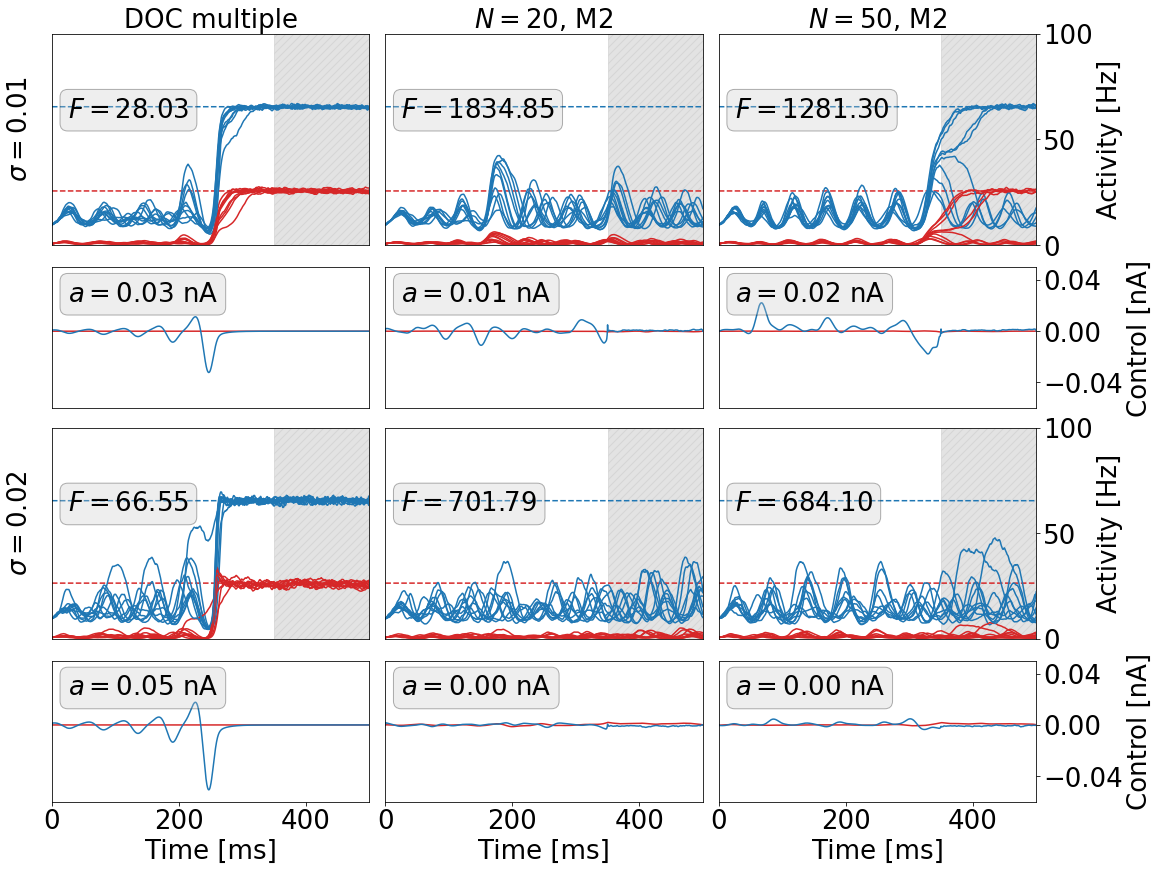

In [21]:
fs_ = 26
fig, ax = plt.subplots(4, 3, figsize=(16,12), constrained_layout=True, facecolor='white',
                       gridspec_kw={'height_ratios': [3,2,3,2]})
#fig.suptitle('Point b', fontsize=fs_)
plot_realizations = 10
i = 50

t_array = np.arange(0,dur+aln.params.dt,aln.params.dt)
ax[0,0].set_title('DOC multiple', fontsize=fs_)

setinit(initVars, aln)
aln.params.duration = dur
target_ = aln.getZeroTarget()

for i_sigma in range(2):
    
    target_[0,0,:] = target[i_sigma][0,0,-1]
    target_[0,1,:] = target[i_sigma][0,1,-1]
    
    for i_noise in range(3):
        
        noise_realizations = noise_realizations_array[i_noise]
        sigma_ou = sigma_ou_array[i_sigma]
        aln.params.sigma_ou = sigma_ou
        
        if i_noise != 0:
            ax[0,i_noise].set_title(r'$N=$' + '{}'.format(noise_realizations) + ', M2', fontsize=fs_)

        ax[2*i_sigma+1,i_noise].plot( t_array, control_[i_sigma][i_noise][0,0,100:-100]/5., color=exc_red)
        ax[2*i_sigma+1,i_noise].plot( t_array, control_[i_sigma][i_noise][0,1,100:-100]/5., color=inh_blue)
        
        ax[2*i_sigma,i_noise].plot( t_array, target_[0,0,:], linestyle='--', color=exc_red)
        ax[2*i_sigma,i_noise].plot( t_array, target_[0,1,:], linestyle='--', color=inh_blue)

        for indexx in range(plot_realizations):
            aln.run(control=control_[i_sigma][i_noise][:,:,100:-100])
            ax[2*i_sigma,i_noise].plot( t_array, aln.rates_exc[0,:], color=exc_red)
            ax[2*i_sigma,i_noise].plot( t_array, aln.rates_inh[0,:], color=inh_blue)

        ax[2*i_sigma,i_noise].text(0.05, 0.7, r'$F = $' + '{:.2f}'.format(cost_final_mean[i_sigma, i_noise]),
                horizontalalignment='left', verticalalignment='top', transform=ax[2*i_sigma,i_noise].transAxes,
                bbox=dict(boxstyle='round', facecolor=midgrey, alpha=0.3), fontsize=fs_)
        
        ax[2*i_sigma+1,i_noise].text(0.05, 0.9, r'$a = $' + '{:.2f} nA'.format(
            max( np.amax(np.abs(control_[i_sigma][i_noise][0,0,100:-100]/5.)),
               np.amax(np.abs(control_[i_sigma][i_noise][0,1,100:-100]/5.))) ),
            horizontalalignment='left', verticalalignment='top', transform=ax[2*i_sigma+1,i_noise].transAxes,
            bbox=dict(boxstyle='round', facecolor=midgrey, alpha=0.3), fontsize=fs_)

for j in range(4):
    for k in range(3):
        ax[j,k].tick_params(axis='x', labelsize=fs_)
        ax[j,k].tick_params(axis='y', labelsize=fs_)
        ax[j,k].set_xlim(0,dur)
        ax[j,k].grid(False)
        if j != 3:
            ax[j,k].set_xticks([])
        else:
            ax[j,k].set_xlabel('Time [ms]', fontsize=fs_)
        ax[j,k].set_yticks([])
        if j%2 == 0:
            ax[j,k].set_ylim(0,100)
            sigma_ou = sigma_ou_array[int(j/2)]
            ax[j,k].axvspan( dur*trans_time, dur, facecolor=midgrey,
                            alpha=0.5, zorder=-1, hatch='///', edgecolor = midgrey)
        elif j%2 == 1:
            ax[j,k].set_ylim(-0.06,0.05)
            
    if j%2 == 0:
        ax[j,-1].set_yticks(np.arange(0,110,50))
        ax[j,-1].set_ylabel('Activity [Hz]', fontsize=fs_)
        ax[j,-1].yaxis.set_label_position("right")
        ax[j,-1].yaxis.tick_right()
        ax[j,0].text(-0.1,0.3, r'$\sigma=$'+'{:.2f}'.format(sigma_ou_array[int(j/2)]), rotation=90, size=fs_,
                 verticalalignment='bottom', horizontalalignment='center', transform=ax[j,0].transAxes)
    
    elif j%2 == 1:     
        ax[j,-1].set_yticks(np.arange(-0.04,0.041,0.04))
        ax[j,-1].set_ylabel('Control [nA]', fontsize=fs_)
        ax[j,-1].yaxis.set_label_position("right")
        ax[j,-1].yaxis.tick_right()

filename_ = nb[:-6] + '.png'
    
fig.savefig(filename_)
fig.savefig(os.path.join(savepath, filename_))
plt.show()

In [45]:
aln.params.duration = dur
setinit(initVars, aln)

for i_sigma in range(len(sigma_ou_array)):
    for i_noise in range(len(noise_realizations_array)):
        
        if i_noise in []:
            continue
            
        if i_sigma in []:
            continue
            
        noise_realizations = noise_realizations_array[i_noise]
        sigma_ou = sigma_ou_array[i_sigma]
        aln.params.sigma_ou = sigma_ou

        init_control = aln.getZeroControl()           
        init_control[:,:,:] = control_[i_sigma][i_noise][:,:,100:-100]
        T = int(1 + dur/aln.params.dt)
        dt = aln.params.dt

        target_ = target[i_sigma].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000

        cost_final = 0.
        cs = cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

        for n_ in range(noise_realizations_final):
            state_ = fo.updateState(aln, init_control)
            cost_final += cost.numba_cost_precision_int(1,T,dt,w_p[i_sigma],state_, target_, list(prec_vars) )

        cost_final_mean[i_sigma, i_noise] = cs + cost_final / noise_realizations_final
        print('mean = ', cost_final_mean[i_sigma, i_noise])

mean =  25.718907769768553
mean =  1.8868494903810706
mean =  2.36341264130255
mean =  51.29069254861261
mean =  3.1512339004106824
mean =  3.440352161506058


In [ ]:
# M2 better than M3 and M4

In [22]:
control_1 = [ [None] * n_noise, [None] * n_noise, [None] * n_noise ]

In [23]:
for i_sigma in range(2):
    
    cost.setParams(w_p[i_sigma], w_e, w_s)
    
    for i_noise in [1,2]:
        
        if i_sigma in []:
            continue
            
        if i_noise in []:
            continue

        noise_realizations = noise_realizations_array[i_noise]
        sigma_ou = sigma_ou_array[i_sigma]
        aln.params.sigma_ou = sigma_ou
        
        print(noise_realizations)
            
        n_ = 0
        n_max = noise_realizations_array[i_noise]
        control_sum = np.zeros(( init_control_noisefree[:,:,:].shape ))
        aln.params.duration = dur
        control_init = aln.getZeroControl()    

        while n_ < n_max:

            print('--------', n_)
            aln.params.duration = dur

            setinit(initVars, aln)
            c_vars = [1]

            bestControl, bestState, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                control_init, target[i_sigma], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                noise_real=0, init_params = initVars)

            if np.isnan(c_).any():
                continue

            control_init = bestControl[:,:,100:-100].copy()
            c_vars = [0,1]

            bestControl, bestState, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                control_init, target[i_sigma], c_scheme, u_mat, u_scheme, max_iteration_ = max_it-init_it,
                tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                noise_real=0, init_params = initVars)

            if np.isnan(c_).any():
                continue

            control_sum += bestControl
            n_ += 1

        control_1[i_sigma][i_noise] = control_sum / n_max

set cost params:  0.007606898297233717 0.0 1.0 0.0
20
-------- 0
interpolate adjoint :  True True True
initial cost =  1888.5350530190387
RUN  0 , total integrated cost =  1888.5350530190387
Gradient descend method:  None
RUN  1 , total integrated cost =  8.170418171498085
RUN  2 , total integrated cost =  8.099283433438647
RUN  3 , total integrated cost =  8.039305320282374
RUN  3 , total integrated cost =  8.039305320282374
Improved over  3  iterations in  0.3537743319902802  seconds by  99.57430997600862  percent.
interpolate adjoint :  True True True
initial cost =  9.063189635967206
RUN  0 , total integrated cost =  9.063189635967206
Gradient descend method:  None
RUN  1 , total integrated cost =  1.5637952254786747
RUN  2 , total integrated cost =  1.3117559685129052
RUN  3 , total integrated cost =  1.3271333502521578
RUN  4 , total integrated cost =  1.2974138220077225
RUN  5 , total integrated cost =  1.1766232121321933
RUN  6 , total integrated cost =  0.992018536545998
RUN  

RUN  8 , total integrated cost =  1.177381942123338
RUN  9 , total integrated cost =  1.2085537403177766
RUN  10 , total integrated cost =  1.0808017487007717
RUN  11 , total integrated cost =  1.1091708703936822
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  1.0651188230820459
Control only changes marginally.
RUN  12 , total integrated cost =  1.0651188230820459
Improved over  12  iterations in  3.4460565040062647  seconds by  41.75739784033547  percent.
-------- 6
interpolate adjoint :  True True True
initial cost =  1.6925332306604335
RUN  0 , total integrated cost =  1.6925332306604335
Gradient descend method:  None
RUN  1 , total integrated cost =  1.4251950660975303
RUN  2 , total integrated cost =  1.4861703405380884
RUN  3 , total integrated cost =  1.4941167294291353
RUN  3 , total integrated cost =  1.4941167294291353
Improved over  3  iterations in  0.3512517439958174  seconds by  11.723049074426456  percent.
interpolate 

RUN  8 , total integrated cost =  0.7431004231280003
RUN  9 , total integrated cost =  0.698418000073954
RUN  10 , total integrated cost =  0.7025146326948257
RUN  11 , total integrated cost =  0.7245508026655623
RUN  12 , total integrated cost =  0.6424585243576537
RUN  12 , total integrated cost =  0.6424585243576537
Improved over  12  iterations in  4.169669220005744  seconds by  49.20335599776472  percent.
-------- 12
interpolate adjoint :  True True True
initial cost =  1.1052639605903132
RUN  0 , total integrated cost =  1.1052639605903132
Gradient descend method:  None
RUN  1 , total integrated cost =  0.9568046540873185
RUN  2 , total integrated cost =  1.1425021618128657
RUN  3 , total integrated cost =  1.172313355957178
RUN  3 , total integrated cost =  1.172313355957178
Improved over  3  iterations in  0.6904430860013235  seconds by  -6.066369460834878  percent.
interpolate adjoint :  True True True
initial cost =  1.3298256613246204
RUN  0 , total integrated cost =  1.3298

RUN  1 , total integrated cost =  1.2532043261213448
RUN  2 , total integrated cost =  1.1403101700437936
RUN  3 , total integrated cost =  1.1078314734274275
RUN  4 , total integrated cost =  1.0473360556382898
RUN  5 , total integrated cost =  1.037189844705802
RUN  6 , total integrated cost =  0.9304556968067661
RUN  7 , total integrated cost =  0.9280252054535467
RUN  8 , total integrated cost =  0.8544230756227973
RUN  9 , total integrated cost =  0.7278216839914585
RUN  10 , total integrated cost =  0.7414527296542106
RUN  11 , total integrated cost =  0.6755055859593398
RUN  12 , total integrated cost =  0.6003170627659677
RUN  12 , total integrated cost =  0.6003170627659677
Improved over  12  iterations in  2.150993771996582  seconds by  59.990316024585525  percent.
-------- 18
interpolate adjoint :  True True True
initial cost =  1.4858782102103794
RUN  0 , total integrated cost =  1.4858782102103794
Gradient descend method:  None
RUN  1 , total integrated cost =  1.386988791

RUN  1 , total integrated cost =  1.4515228793441928
RUN  2 , total integrated cost =  1.4418607664662675
RUN  3 , total integrated cost =  1.3399406949926893
RUN  4 , total integrated cost =  1.2022325052360578
RUN  5 , total integrated cost =  1.2264281445737386
RUN  6 , total integrated cost =  1.1385614913295
RUN  7 , total integrated cost =  1.0212582175934903
RUN  8 , total integrated cost =  0.9438933836827967
RUN  9 , total integrated cost =  0.8875978590308082
RUN  10 , total integrated cost =  0.8463646603746511
RUN  11 , total integrated cost =  0.7600111137160721
RUN  12 , total integrated cost =  0.6961228340661527
RUN  12 , total integrated cost =  0.6961228340661527
Improved over  12  iterations in  2.553641497011995  seconds by  55.75136257034825  percent.
-------- 4
interpolate adjoint :  True True True
initial cost =  1868.406727211323
RUN  0 , total integrated cost =  1868.406727211323
Gradient descend method:  None
RUN  1 , total integrated cost =  11.48286308798661

RUN  1 , total integrated cost =  2.640825199551167
RUN  2 , total integrated cost =  2.571700221392587
RUN  3 , total integrated cost =  2.4228300439221404
RUN  4 , total integrated cost =  2.291942059329495
RUN  5 , total integrated cost =  2.255864555688394
RUN  6 , total integrated cost =  2.1288394754945745
RUN  7 , total integrated cost =  2.0189375641744043
RUN  8 , total integrated cost =  2.026501483971612
RUN  9 , total integrated cost =  2.0654624103556616
step size too small or too large
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  1.9514467137415545
Control only changes marginally.
RUN  10 , total integrated cost =  1.9514467137415545
Improved over  10  iterations in  2.3347513710032217  seconds by  43.38870479690756  percent.
-------- 10
interpolate adjoint :  True True True
initial cost =  2.8486624835146572
RUN  0 , total integrated cost =  2.8486624835146572
Gradient descend method:  None
RUN  1 , total integrated

RUN  1 , total integrated cost =  1.1532814758909513
RUN  2 , total integrated cost =  1.0907731883971503
RUN  3 , total integrated cost =  1.092425245843727
RUN  4 , total integrated cost =  1.0468815276987782
RUN  5 , total integrated cost =  1.0642456274610628
RUN  6 , total integrated cost =  1.0236632598579554
RUN  7 , total integrated cost =  1.0536622575736139
RUN  8 , total integrated cost =  0.9894485462498204
RUN  9 , total integrated cost =  0.8884574097255813
RUN  10 , total integrated cost =  0.8487835081466713
RUN  11 , total integrated cost =  0.9206414520055948
RUN  12 , total integrated cost =  0.9180247037321392
RUN  12 , total integrated cost =  0.9180247037321392
Improved over  12  iterations in  2.3011993300024187  seconds by  30.737241644010425  percent.
-------- 16
interpolate adjoint :  True True True
initial cost =  1926.9802584908502
RUN  0 , total integrated cost =  1926.9802584908502
Gradient descend method:  None
RUN  1 , total integrated cost =  1.29379550

RUN  2 , total integrated cost =  0.9562542567825976
RUN  3 , total integrated cost =  0.9573596688119657
RUN  3 , total integrated cost =  0.9573596688119657
Improved over  3  iterations in  0.3445716900023399  seconds by  17.519156563502435  percent.
interpolate adjoint :  True True True
initial cost =  1.1185529024167375
RUN  0 , total integrated cost =  1.1185529024167375
Gradient descend method:  None
RUN  1 , total integrated cost =  0.8070361438772904
RUN  2 , total integrated cost =  0.6794152724754828
RUN  3 , total integrated cost =  0.7464612837862579
RUN  4 , total integrated cost =  0.6011010641573519
RUN  5 , total integrated cost =  0.5834361494759882
RUN  6 , total integrated cost =  0.5860554071152025
RUN  7 , total integrated cost =  0.4940630039288273
RUN  8 , total integrated cost =  0.6445425586609981
RUN  9 , total integrated cost =  0.498028497351791
RUN  10 , total integrated cost =  0.5141261288922129
RUN  11 , total integrated cost =  0.4777674362046856
RUN  1

RUN  1 , total integrated cost =  2.123938947726097
RUN  2 , total integrated cost =  2.1425804305594354
RUN  3 , total integrated cost =  2.1473163407135605
RUN  4 , total integrated cost =  2.009931398602549
RUN  5 , total integrated cost =  2.017694878297715
RUN  6 , total integrated cost =  1.9887979659475428
RUN  7 , total integrated cost =  1.9287758524347591
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  1.8540181561070534
Control only changes marginally.
RUN  8 , total integrated cost =  1.8540181561070534
Improved over  8  iterations in  1.9286514340055874  seconds by  20.506532411794936  percent.
-------- 28
interpolate adjoint :  True True True
initial cost =  2.4120026146564584
RUN  0 , total integrated cost =  2.4120026146564584
Gradient descend method:  None
RUN  1 , total integrated cost =  2.163658737231335
RUN  2 , total integrated cost =  2.0901325867546987
RUN  3 , total integrated 

RUN  1 , total integrated cost =  2.9482407477747774
RUN  2 , total integrated cost =  2.9621802468424185
RUN  3 , total integrated cost =  2.5648073236314826
RUN  4 , total integrated cost =  2.657266611825673
RUN  5 , total integrated cost =  2.905121910648549
RUN  6 , total integrated cost =  1.5601937118692364
RUN  7 , total integrated cost =  1.9979753175144448
RUN  8 , total integrated cost =  1.6441883710293361
RUN  9 , total integrated cost =  1.624803859147087
RUN  10 , total integrated cost =  1.51875913946952
RUN  11 , total integrated cost =  1.507940338188237
RUN  12 , total integrated cost =  1.4661945191761265
RUN  12 , total integrated cost =  1.4661945191761265
Improved over  12  iterations in  2.5461481669917703  seconds by  99.91611274154992  percent.
-------- 34
interpolate adjoint :  True True True
initial cost =  1825.2808107377402
RUN  0 , total integrated cost =  1825.2808107377402
Gradient descend method:  None
RUN  1 , total integrated cost =  1.96791077590139

RUN  1 , total integrated cost =  2.4052837437451466
RUN  2 , total integrated cost =  2.2665842312831566
RUN  3 , total integrated cost =  2.21185168442543
RUN  4 , total integrated cost =  2.1825438372521915
RUN  5 , total integrated cost =  1.9917099671088585
RUN  6 , total integrated cost =  2.0004660616916716
RUN  7 , total integrated cost =  2.0802219009525995
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  1.887722012704301
RUN  9 , total integrated cost =  1.8706652150751584
RUN  10 , total integrated cost =  1.6735927809682376
RUN  11 , total integrated cost =  1.5505013292872638
RUN  12 , total integrated cost =  1.5713744688189086
RUN  12 , total integrated cost =  1.5713744688189086
Improved over  12  iterations in  2.6279686550115002  seconds by  40.77135563270269  percent.
-------- 40
interpolate adjoint :  True True True
initial cost =  2.573584681761394
RUN  0 , total integrated cost =  2.573584681761394
Gradient desce

RUN  3 , total integrated cost =  1.3523286730670272
RUN  3 , total integrated cost =  1.3523286730670272
Improved over  3  iterations in  0.3466787219949765  seconds by  -0.8413712046113204  percent.
interpolate adjoint :  True True True
initial cost =  1.6413259035743302
RUN  0 , total integrated cost =  1.6413259035743302
Gradient descend method:  None
RUN  1 , total integrated cost =  1.1956259651489565
RUN  2 , total integrated cost =  1.1031645696789998
RUN  3 , total integrated cost =  1.0566474608863734
RUN  4 , total integrated cost =  0.8843665750729405
RUN  5 , total integrated cost =  0.9024162985341811
RUN  6 , total integrated cost =  0.9533084136922123
RUN  7 , total integrated cost =  0.8775037515638022
RUN  8 , total integrated cost =  0.850354625242641
RUN  9 , total integrated cost =  0.8755613139214495
RUN  10 , total integrated cost =  0.830375014127539
RUN  11 , total integrated cost =  0.6997305918444341
RUN  12 , total integrated cost =  0.5913043337800991
RUN  

RUN  2 , total integrated cost =  1.3984186825932055
RUN  3 , total integrated cost =  1.464398381521457
RUN  3 , total integrated cost =  1.464398381521457
Improved over  3  iterations in  0.3292893359903246  seconds by  56.26697064361061  percent.
interpolate adjoint :  True True True
initial cost =  1.4590787356471953
RUN  0 , total integrated cost =  1.4590787356471953
Gradient descend method:  None
RUN  1 , total integrated cost =  1.0529170256803067
RUN  2 , total integrated cost =  1.0269084345011763
RUN  3 , total integrated cost =  1.07866677632719
RUN  4 , total integrated cost =  1.0380995380026017
RUN  5 , total integrated cost =  1.031570935856874
RUN  6 , total integrated cost =  0.9664572594006482
RUN  7 , total integrated cost =  0.8972114125573281
RUN  8 , total integrated cost =  0.99783330021607
RUN  9 , total integrated cost =  0.9653226644306312
RUN  10 , total integrated cost =  0.8911640528076741
RUN  11 , total integrated cost =  0.9148616514454437
RUN  12 , tot

RUN  2 , total integrated cost =  3.3908428110781665
RUN  3 , total integrated cost =  2.5814444885326875
RUN  3 , total integrated cost =  2.5814444885326875
Improved over  3  iterations in  0.45439817300939467  seconds by  20.284140639080718  percent.
interpolate adjoint :  True True True
initial cost =  2.6092748998012354
RUN  0 , total integrated cost =  2.6092748998012354
Gradient descend method:  None
RUN  1 , total integrated cost =  2.3245086527961103
RUN  2 , total integrated cost =  2.1042377525990714
RUN  3 , total integrated cost =  2.3281615889479683
RUN  4 , total integrated cost =  2.380872346360802
RUN  5 , total integrated cost =  2.338510770751578
RUN  6 , total integrated cost =  2.328632173087484
RUN  7 , total integrated cost =  2.0991434966124647
RUN  8 , total integrated cost =  1.9641450884707488
RUN  9 , total integrated cost =  1.922575828722486
RUN  10 , total integrated cost =  1.8024131593068216
RUN  11 , total integrated cost =  1.5319852459195868
RUN  12 

RUN  2 , total integrated cost =  2.3478996061970667
RUN  3 , total integrated cost =  2.2790679956924453
RUN  3 , total integrated cost =  2.2790679956924453
Improved over  3  iterations in  0.33763300999999046  seconds by  23.451575104694044  percent.
interpolate adjoint :  True True True
initial cost =  1.9931081060115536
RUN  0 , total integrated cost =  1.9931081060115536
Gradient descend method:  None
RUN  1 , total integrated cost =  1.5372909193246331
RUN  2 , total integrated cost =  1.4546532260723521
RUN  3 , total integrated cost =  1.6189223678580298
RUN  4 , total integrated cost =  1.6046703984226411
RUN  5 , total integrated cost =  1.6267602558173004
RUN  6 , total integrated cost =  1.4973065303018642
RUN  7 , total integrated cost =  1.6192870916530677
RUN  8 , total integrated cost =  1.5879293811700992
RUN  9 , total integrated cost =  1.4374034784971303
RUN  10 , total integrated cost =  1.3554659992268294
RUN  11 , total integrated cost =  1.3629863480212818
RUN 

RUN  2 , total integrated cost =  1.090314824867989
RUN  3 , total integrated cost =  1.0891841583256536
RUN  3 , total integrated cost =  1.0891841583256536
Improved over  3  iterations in  0.4788490779901622  seconds by  30.818342319834272  percent.
interpolate adjoint :  True True True
initial cost =  3.0081394745943144
RUN  0 , total integrated cost =  3.0081394745943144
Gradient descend method:  None
RUN  1 , total integrated cost =  1.4513601084367722
RUN  2 , total integrated cost =  1.394921910118788
RUN  3 , total integrated cost =  1.4380625032511445
RUN  4 , total integrated cost =  1.435972988218465
RUN  5 , total integrated cost =  1.4810402594106054
RUN  6 , total integrated cost =  1.4551539210906104
RUN  7 , total integrated cost =  1.404482727062224
RUN  8 , total integrated cost =  1.3379652095427592
RUN  9 , total integrated cost =  1.3047954438813862
RUN  10 , total integrated cost =  1.046449670615905
RUN  11 , total integrated cost =  1.1044234588238737
RUN  12 , 

RUN  2 , total integrated cost =  6.931400393491996
RUN  3 , total integrated cost =  4.210428054755968
RUN  3 , total integrated cost =  4.210428054755968
Improved over  3  iterations in  0.3311063470027875  seconds by  99.3482007875291  percent.
interpolate adjoint :  True True True
initial cost =  4.376258958317464
RUN  0 , total integrated cost =  4.376258958317464
Gradient descend method:  None
RUN  1 , total integrated cost =  3.5390122822613805
RUN  2 , total integrated cost =  3.4016005096511877
RUN  3 , total integrated cost =  3.104281698819555
RUN  4 , total integrated cost =  3.0332664110620224
RUN  5 , total integrated cost =  3.0971298478558293
RUN  6 , total integrated cost =  2.6535013018692197
RUN  7 , total integrated cost =  2.393940201266639
RUN  8 , total integrated cost =  2.319929122755788
RUN  9 , total integrated cost =  2.0904930816848193
RUN  10 , total integrated cost =  1.5471851411634796
RUN  11 , total integrated cost =  1.261430587603508
step size too sm

RUN  2 , total integrated cost =  1.5215788753104866
RUN  3 , total integrated cost =  1.2561228001569291
RUN  3 , total integrated cost =  1.2561228001569291
Improved over  3  iterations in  0.3456014860130381  seconds by  93.71129106292884  percent.
interpolate adjoint :  True True True
initial cost =  1.4716733317930144
RUN  0 , total integrated cost =  1.4716733317930144
Gradient descend method:  None
RUN  1 , total integrated cost =  0.881877020960158
RUN  2 , total integrated cost =  0.7525055873802943
RUN  3 , total integrated cost =  0.7484625953261761
RUN  4 , total integrated cost =  0.8378127215202618
RUN  5 , total integrated cost =  0.8074647596862783
RUN  6 , total integrated cost =  0.8131415775143571
RUN  7 , total integrated cost =  0.6450713821566108
RUN  8 , total integrated cost =  0.551209023757381
RUN  9 , total integrated cost =  0.7077381474674914
RUN  10 , total integrated cost =  0.6412749537236424
RUN  11 , total integrated cost =  0.600521904563855
RUN  12 ,

RUN  1 , total integrated cost =  1.659976758427323
RUN  2 , total integrated cost =  1.701993660673748
RUN  3 , total integrated cost =  1.7711975617764266
RUN  3 , total integrated cost =  1.7711975617764266
Improved over  3  iterations in  0.34225646599952597  seconds by  -0.24035999890298854  percent.
interpolate adjoint :  True True True
initial cost =  1.6798572847323618
RUN  0 , total integrated cost =  1.6798572847323618
Gradient descend method:  None
RUN  1 , total integrated cost =  1.4527982127989238
RUN  2 , total integrated cost =  1.4377223158226804
RUN  3 , total integrated cost =  1.10938053388423
RUN  4 , total integrated cost =  0.9972032505135571
RUN  5 , total integrated cost =  0.8875863271773581
RUN  6 , total integrated cost =  0.8190165383004746
RUN  7 , total integrated cost =  0.8664947726897017
RUN  8 , total integrated cost =  0.8267288222433196
RUN  9 , total integrated cost =  0.9363004876748985
RUN  10 , total integrated cost =  0.7849262995704867
RUN  11

RUN  1 , total integrated cost =  1.6221282050335681
RUN  2 , total integrated cost =  12.958273528626124
RUN  3 , total integrated cost =  2.562722177082464
RUN  3 , total integrated cost =  2.562722177082464
Improved over  3  iterations in  0.3373709609877551  seconds by  -9.701216739976275  percent.
interpolate adjoint :  True True True
initial cost =  2.7459421308739236
RUN  0 , total integrated cost =  2.7459421308739236
Gradient descend method:  None
RUN  1 , total integrated cost =  2.340729410190925
RUN  2 , total integrated cost =  2.019476001527022
RUN  3 , total integrated cost =  2.3610441516899496
RUN  4 , total integrated cost =  2.1094099342801718
RUN  5 , total integrated cost =  1.9493856167943884
RUN  6 , total integrated cost =  1.857668526526654
RUN  7 , total integrated cost =  1.8736789020190707
RUN  8 , total integrated cost =  2.0729497816247644
RUN  9 , total integrated cost =  1.8189807555072055
RUN  10 , total integrated cost =  1.7411411713323848
RUN  11 , t

RUN  2 , total integrated cost =  1.513351974715965
RUN  3 , total integrated cost =  1.4156203291181757
RUN  3 , total integrated cost =  1.4156203291181757
Improved over  3  iterations in  0.34338262099481653  seconds by  9.379650037150427  percent.
interpolate adjoint :  True True True
initial cost =  1.3356852496996259
RUN  0 , total integrated cost =  1.3356852496996259
Gradient descend method:  None
RUN  1 , total integrated cost =  1.2304603070548343
RUN  2 , total integrated cost =  1.1560979193408636
RUN  3 , total integrated cost =  1.107925409680891
RUN  4 , total integrated cost =  1.229733286405849
RUN  5 , total integrated cost =  1.0481594918212735
RUN  6 , total integrated cost =  1.3095435455351079
RUN  7 , total integrated cost =  1.3242730411942767
RUN  8 , total integrated cost =  0.9610757059854523
RUN  9 , total integrated cost =  0.9949730660531045
RUN  10 , total integrated cost =  0.7208397771246731
RUN  11 , total integrated cost =  0.7618279587279876
RUN  12 

RUN  1 , total integrated cost =  1.8319186293117
RUN  2 , total integrated cost =  1.9472261396962876
RUN  3 , total integrated cost =  1.8299368371679572
RUN  3 , total integrated cost =  1.8299368371679572
Improved over  3  iterations in  0.33223980499315076  seconds by  68.31045925758102  percent.
interpolate adjoint :  True True True
initial cost =  2.1316438309917087
RUN  0 , total integrated cost =  2.1316438309917087
Gradient descend method:  None
RUN  1 , total integrated cost =  1.6990561599270966
RUN  2 , total integrated cost =  1.5600669088260382
RUN  3 , total integrated cost =  1.1669728441472336
RUN  4 , total integrated cost =  1.142506599443334
RUN  5 , total integrated cost =  0.9566681971027398
RUN  6 , total integrated cost =  1.031289017944276
RUN  7 , total integrated cost =  1.168268564529653
RUN  8 , total integrated cost =  1.0585194747291033
RUN  9 , total integrated cost =  1.024382035224149
RUN  10 , total integrated cost =  0.9131110118316783
RUN  11 , tot

RUN  2 , total integrated cost =  0.9764862859716708
RUN  3 , total integrated cost =  1.3167768214936186
RUN  3 , total integrated cost =  1.3167768214936186
Improved over  3  iterations in  0.5141226570121944  seconds by  10.477874573544938  percent.
interpolate adjoint :  True True True
initial cost =  3.1039842469244197
RUN  0 , total integrated cost =  3.1039842469244197
Gradient descend method:  None
RUN  1 , total integrated cost =  1.1223874547679098
RUN  2 , total integrated cost =  1.0119149750474397
RUN  3 , total integrated cost =  0.8659658011653335
RUN  4 , total integrated cost =  0.6798233361672235
RUN  5 , total integrated cost =  0.6871876719792169
RUN  6 , total integrated cost =  0.6662341308733348
RUN  7 , total integrated cost =  0.6056065181481093
RUN  8 , total integrated cost =  0.6802297295833808
RUN  9 , total integrated cost =  0.5776451941455197
RUN  10 , total integrated cost =  0.5189652616244296
RUN  11 , total integrated cost =  0.5207453717135178
RUN  

RUN  12 , total integrated cost =  0.6130375418460065
Improved over  12  iterations in  2.6784420879994286  seconds by  71.29607050799683  percent.
-------- 47
interpolate adjoint :  True True True
initial cost =  735.381845368488
RUN  0 , total integrated cost =  735.381845368488
Gradient descend method:  None
RUN  1 , total integrated cost =  2.073729584114683
RUN  2 , total integrated cost =  2.9746187053374062
RUN  3 , total integrated cost =  2.234270756113879
RUN  3 , total integrated cost =  2.234270756113879
Improved over  3  iterations in  0.36091640900122  seconds by  99.69617542638758  percent.
interpolate adjoint :  True True True
initial cost =  2.6282321536874167
RUN  0 , total integrated cost =  2.6282321536874167
Gradient descend method:  None
RUN  1 , total integrated cost =  1.8555640899331454
RUN  2 , total integrated cost =  1.6936832418737127
RUN  3 , total integrated cost =  1.2226010272809646
RUN  4 , total integrated cost =  1.1244332582715093
RUN  5 , total int

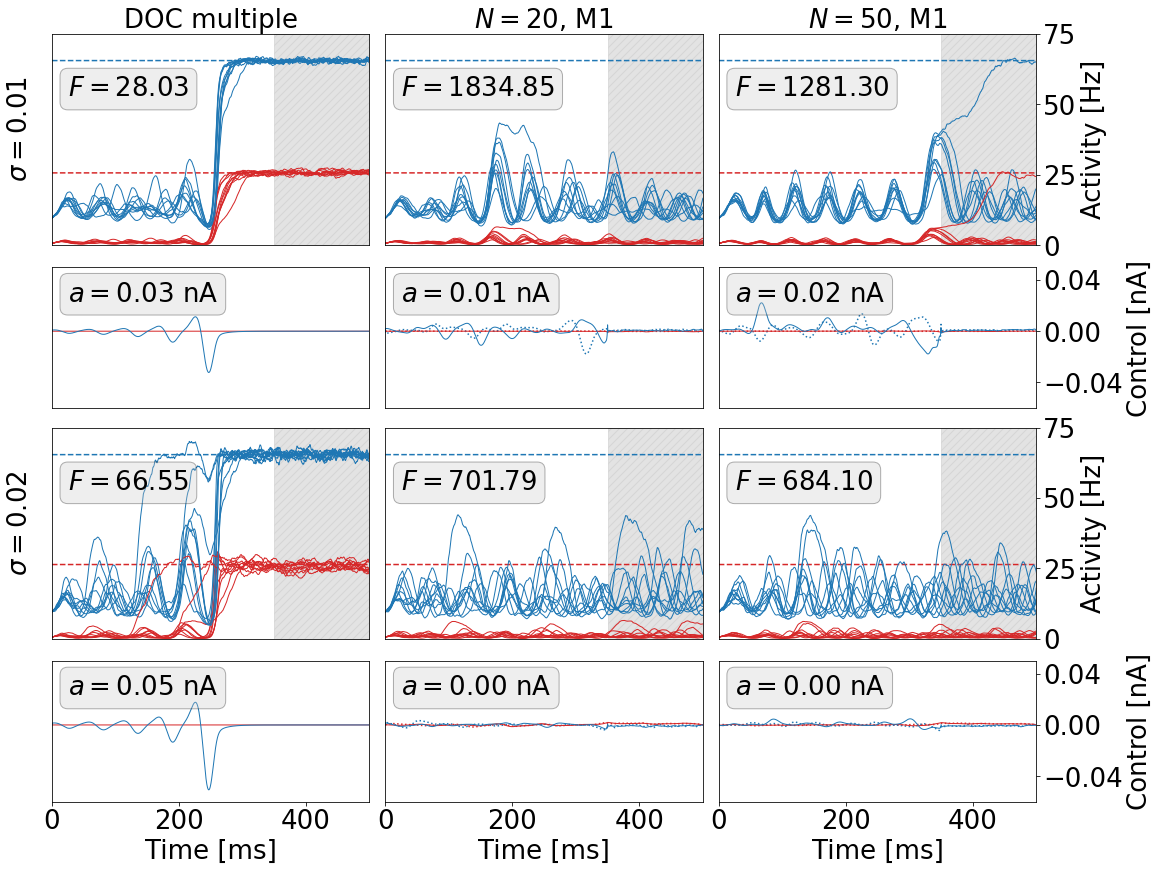

In [27]:
fig, ax = plt.subplots(4, 3, figsize=(16,12), constrained_layout=True, facecolor='white',
                       gridspec_kw={'height_ratios': [3,2,3,2]})

t_array = np.arange(0,dur+aln.params.dt,aln.params.dt)
ax[0,0].set_title('DOC multiple', fontsize=fs_)

setinit(initVars, aln)
aln.params.duration = dur
target_ = aln.getZeroTarget()

for i_sigma in range(2):
    
    target_[0,0,:] = target[i_sigma][0,0,-1]
    target_[0,1,:] = target[i_sigma][0,1,-1]
    
    for i_noise in range(3):
        
        noise_realizations = noise_realizations_array[i_noise]
        sigma_ou = sigma_ou_array[i_sigma]
        aln.params.sigma_ou = sigma_ou
        
        if i_noise != 0:
            ax[0,i_noise].set_title(r'$N=$' + '{}'.format(noise_realizations) + ', M1', fontsize=fs_)
            ax[2*i_sigma+1,i_noise].plot( t_array, control_1[i_sigma][i_noise][0,0,100:-100]/5.,
                                         color=exc_red, linestyle='dotted')
            ax[2*i_sigma+1,i_noise].plot( t_array, control_1[i_sigma][i_noise][0,1,100:-100]/5.,
                                         color=inh_blue, linestyle='dotted')

        ax[2*i_sigma+1,i_noise].plot( t_array, control_[i_sigma][i_noise][0,0,100:-100]/5.,
                                     color=exc_red, linewidth=1)
        ax[2*i_sigma+1,i_noise].plot( t_array, control_[i_sigma][i_noise][0,1,100:-100]/5.,
                                     color=inh_blue, linewidth=1)
        
        ax[2*i_sigma,i_noise].plot( t_array, target_[0,0,:], linestyle='--', color=exc_red)
        ax[2*i_sigma,i_noise].plot( t_array, target_[0,1,:], linestyle='--', color=inh_blue)

        for indexx in range(plot_realizations):
            aln.run(control=control_[i_sigma][i_noise][:,:,100:-100])
            ax[2*i_sigma,i_noise].plot( t_array, aln.rates_exc[0,:], color=exc_red, linewidth=1)
            ax[2*i_sigma,i_noise].plot( t_array, aln.rates_inh[0,:], color=inh_blue, linewidth=1)

        ax[2*i_sigma,i_noise].text(0.05, 0.8, r'$F = $' + '{:.2f}'.format(cost_final_mean[i_sigma, i_noise]),
                horizontalalignment='left', verticalalignment='top', transform=ax[2*i_sigma,i_noise].transAxes,
                bbox=dict(boxstyle='round', facecolor=midgrey, alpha=0.3), fontsize=fs_)
        
        ax[2*i_sigma+1,i_noise].text(0.05, 0.9, r'$a = $' + '{:.2f} nA'.format(
            max( np.amax(np.abs(control_[i_sigma][i_noise][0,0,100:-100]/5.)),
               np.amax(np.abs(control_[i_sigma][i_noise][0,1,100:-100]/5.))) ),
            horizontalalignment='left', verticalalignment='top', transform=ax[2*i_sigma+1,i_noise].transAxes,
            bbox=dict(boxstyle='round', facecolor=midgrey, alpha=0.3), fontsize=fs_)

for j in range(4):
    for k in range(3):
        ax[j,k].tick_params(axis='x', labelsize=fs_)
        ax[j,k].tick_params(axis='y', labelsize=fs_)
        ax[j,k].set_xlim(0,dur)
        ax[j,k].grid(False)
        if j != 3:
            ax[j,k].set_xticks([])
        else:
            ax[j,k].set_xlabel('Time [ms]', fontsize=fs_)
        ax[j,k].set_yticks([])
        if j%2 == 0:
            ax[j,k].set_ylim(0,75)
            sigma_ou = sigma_ou_array[int(j/2)]
            ax[j,k].axvspan( dur*trans_time, dur, facecolor=midgrey,
                            alpha=0.5, zorder=-1, hatch='///', edgecolor = midgrey)
        elif j%2 == 1:
            ax[j,k].set_ylim(-0.06,0.05)
            
    if j%2 == 0:
        ax[j,-1].set_yticks(np.arange(0,81,25))
        ax[j,-1].set_ylabel('Activity [Hz]', fontsize=fs_)
        ax[j,-1].yaxis.set_label_position("right")
        ax[j,-1].yaxis.tick_right()
        ax[j,0].text(-0.1,0.3, r'$\sigma=$'+'{:.2f}'.format(sigma_ou_array[int(j/2)]), rotation=90, size=fs_,
                 verticalalignment='bottom', horizontalalignment='center', transform=ax[j,0].transAxes)
    
    elif j%2 == 1:     
        ax[j,-1].set_yticks(np.arange(-0.04,0.041,0.04))
        ax[j,-1].set_ylabel('Control [nA]', fontsize=fs_)
        ax[j,-1].yaxis.set_label_position("right")
        ax[j,-1].yaxis.tick_right()

nb = ipyparams.notebook_name
filename_ = nb[:-6] + '_1.png'
    
fig.savefig(filename_)
fig.savefig(os.path.join(savepath, filename_))
plt.show()